## Create water mask in radar coordinate ##

This notebook show two ways of generating water mask in radar coordinates to facilitate InSAR processing in MintPy:

1. Using `generate_mask.py` based on DEM in radar coordiantes with `manually` selected threshold in height.
2. Using `wbd.py` from ISCE to download water mask in geo coordinates and radar-code it using geocode.py from MintPy.

In [1]:
## Examples to generate water mask.
%matplotlib inline
import os
import matplotlib.pyplot as plt
from mintpy import view, geocode

work_dir = os.path.expanduser('~/insarlab/test/FernandinaSenDT128/mintpy')
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/insarlab/test/FernandinaSenDT128/mintpy


## Option 1: Thresholding DEM in radar coordinates using `generate_mask.py`

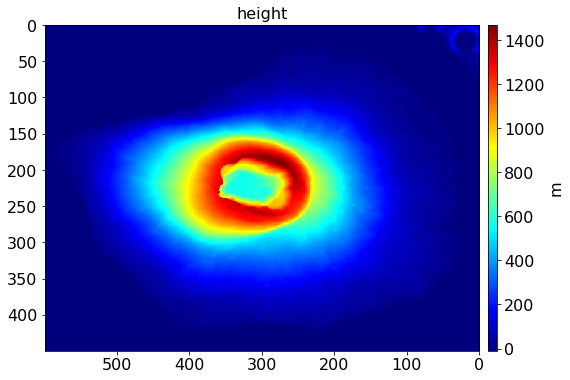

input geometry file: INPUTS/geometryRadar.h5
read INPUTS/geometryRadar.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < -5.5
delete exsited file: waterMask.h5
create HDF5 file: waterMask.h5 with w mode
create dataset /mask of bool       in size of (450, 600)           with compression=None
finished writing to waterMask.h5
time used: 00 mins 0.0 secs.


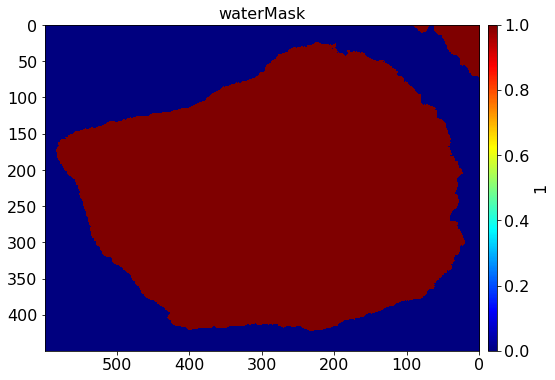

In [2]:
# 1. run view.py to plot the height
# Hover around to see the maximum height on the water (shown in the status bar)
# because height on the water varies in the DEM file with respect to the ellipsoid (*.wgs84 file in ISCE)
view.main('./inputs/geometryRadar.h5 height --noverbose'.split())
# Let's say here the maximum height value on the water you found is -6 m

# 2. run generate_mask.py to create a mask based on the threshold
!generate_mask.py INPUTS/geometryRadar.h5 -m -5.5 -o waterMask.h5
view.main('waterMask.h5 --noverbose'.split())

## Option 2: Download water mask using `wbd.py` from ISCE and radar-code it

geocode.py /Users/yunjunz/insarlab/DEM/swbdLat_S01_N00_Lon_W092_W091.wbd -l inputs/geometryRadar.h5 -o waterBody.h5 --geo2radar
number of processor to be used: 1
--------------------------------------------------
resampling file: /Users/yunjunz/insarlab/DEM/swbdLat_S01_N00_Lon_W092_W091.wbd
reading swbdLat_S01_N00_Lon_W092_W091 from swbdLat_S01_N00_Lon_W092_W091.wbd ...
input source data is not float, change fill_value from NaN to 0.
nearest resampling with kd_tree using 1 processor cores in 0 segments ...
delete exsited file: waterBody.h5
create HDF5 file: waterBody.h5 with w mode
create dataset /swbdLat_S01_N00_Lon_W092_W091 of int8       in size of (450, 600)           with compression=None
finished writing to waterBody.h5
time used: 00 mins 2.8 secs.

input swbdLat_S01_N00_Lon_W092_W091 file: waterBody.h5
read waterBody.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < -0.5
delete exsited file: waterMas

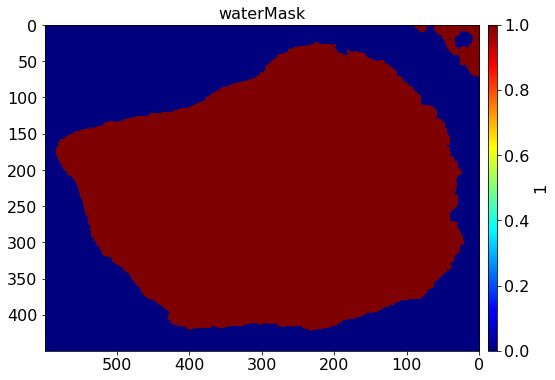

In [3]:
# 1. Downloads water body mask from USGS using wbd.py
# This will create file swbdLat_S01_N00_Lon_W092_W091.wbd in the current directory, or in $DEMDB if it's defined.
# The file contains -1 for water and 0 for land
!wbd.py -1 0 -92 -91

# 2. Convert to radar coordinates
wbd_file = os.path.expandvars('$DEMDB/swbdLat_S01_N00_Lon_W092_W091.wbd')
scp_args = '{} -l inputs/geometryRadar.h5 -o waterBody.h5 --geo2radar'.format(wbd_file)
geocode.main(scp_args.split())

# 3. Adjust value for MintPy: 0 for water and 1 for land
!generate_mask.py waterBody.h5 -m -0.5 -o waterMask.h5
view.main('waterMask.h5 --flip-lr --noverbose'.split())